In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Concatenate, UpSampling2D

In [4]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from sklearn.model_selection import train_test_split

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

data_dir = 'dataset_patches'  # Replace this with the actual path to your data directory

images_folder = 'train/images'
images = os.listdir(os.path.join(data_dir, images_folder))

# List of corresponding label image file names (assuming they're in a folder named 'labels')
labels_folder = 'train/labels'
labels = os.listdir(os.path.join(data_dir, labels_folder))

# Load images and labels
width, height = 256, 256
def load_images(file_list, folder):
    loaded_images = []
    for file_name in file_list:
        img = Image.open(os.path.join(data_dir, folder, file_name))
        # Preprocess images (resize, normalize, etc.)
        img = img.resize((width, height))
        img = np.array(img) / 255.0  # Normalize pixel values
        loaded_images.append(img)
    return np.array(loaded_images)

# Load images and labels using the function
X = load_images(images, images_folder)
y = load_images(labels, labels_folder)

# Split Data into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


def unet_wound_model(input_shape=(256, 256,3),num_filters=64):
    # Encoder
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer for wound detection (1 channel for binary segmentation)
    outputs = Conv2D(3, 1, activation='sigmoid')(conv5)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

wound_model = unet_wound_model(num_filters=80)
wound_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])


In [ ]:
history2 = wound_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=50)


In [10]:
test_images_folder = '/Users/abhishekmuttath/dataset_patches/test/images'
test_images = os.listdir(os.path.join(data_dir, test_images_folder))

# Load and preprocess test images
def load_test_images(file_list, folder):
    loaded_test_images = []
    for file_name in file_list:
        img = Image.open(os.path.join(data_dir, folder, file_name))
        img = img.resize((width, height))
        img = np.array(img) / 255.0  # Normalize pixel values
        loaded_test_images.append(img)
    return np.array(loaded_test_images)

# Load and preprocess test images using the function
X_test = load_test_images(test_images, test_images_folder)


In [11]:
X_test = load_test_images(test_images, test_images_folder)
predictions = wound_model.predict(X_test)

2023-11-27 19:09:53.024859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 6s 587ms/step


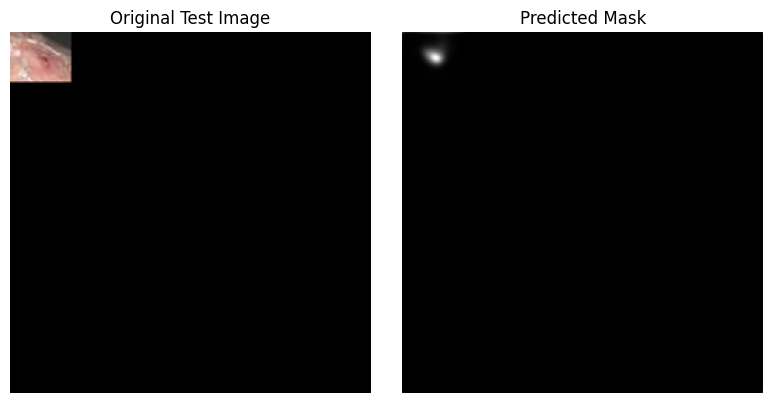

In [22]:
import matplotlib.pyplot as plt

# Choose an index for the test image you want to visualize
index = 220# 

# Visualize the original test image
plt.figure(figsize=(8, 4))

# Assuming X_test contains preprocessed test images
plt.subplot(1, 2, 1)
plt.title('Original Test Image')
plt.imshow(X_test[index])  # Display the original test image
plt.axis('off')

# Visualize the predicted mask
plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predictions[index][:, :, 0], cmap='gray')  # Display the predicted mask (adjust index if needed)
plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
wound_model.save('your_model_ready21.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('your_model_ready21.h5')

# Set the input size of your model
input_size = (256, 256)

# Threshold for classifying as injured or not
threshold = 0.5  # Adjust this threshold based on your model's characteristics

# Function for image preprocessing
def preprocess_image(image):
    # Implement your preprocessing steps here
    
    return cv2.resize(image, input_size)

# Capture video from camera (0 is usually the default camera)
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    # Preprocess the frame
    preprocessed_frame = preprocess_image(frame)

    # Add an additional dimension to match the model's input shape
    input_data = np.expand_dims(preprocessed_frame, axis=0)

    # Make predictions
    predictions = model.predict(input_data)

    # Assuming predictions[0] contains the probability of injury
    injury_probability = predictions[0][0]  # Extract the scalar value

    # Classify as injured or not based on the threshold
    if (injury_probability >= threshold).any():
        result_text = 'Person is Injured'
    else:
        result_text = 'Person is Not Injured'

    # Display the frame with results
    cv2.putText(frame, result_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Result', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


2023-11-27 19:33:14.077590: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-27 19:33:14.077618: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-27 19:33:14.077624: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-27 19:33:14.077664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 19:33:14.077679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-27 19:33:14.676 Python[25177:291634] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCamer

1/1 [==============================] - 0s 181ms/step


2023-11-27 19:33:16.171389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 37ms/step


2023-11-27 19:33:16.401 Python[25177:291634] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 [==============================] - 0s 37ms/step


KeyboardInterrupt: 

In [ ]:
#OPEN CV CODE

import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('your_model_ready21.h5')

# Set the input size of your model
input_size = (256, 256)

# Threshold for classifying as injured or not
threshold = 0.01  

# Function for image preprocessing
def preprocess_image(image):
    # Implement your preprocessing steps here
    
    return cv2.resize(image, input_size)


cap = cv2.VideoCapture(0)

# Flag to track if the person is injured
person_injured = False

while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    # Preprocess the frame
    preprocessed_frame = preprocess_image(frame)

    
    input_data = np.expand_dims(preprocessed_frame, axis=0)

    # Make predictions
    predictions = model.predict(input_data)

    # Assuming predictions[0] contains the probability of injury
    injury_probability = predictions[0][0] 

    # Classify as injured or not based on the threshold
    if np.mean(injury_probability) >= threshold:
        result_text = 'Person is Injured'
        person_injured = True
    else:
        result_text = 'Person is Not Injured'
        person_injured = False

    # Display the frame with results
    cv2.putText(frame, result_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display special message if the person is injured
    if person_injured:
        cv2.putText(frame, 'Person is injured heavily - Immediate treatment required', (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

    cv2.imshow('Result', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


2023-12-01 21:56:01.703452: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-01 21:56:01.703478: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-01 21:56:01.703483: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-01 21:56:01.703544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-01 21:56:01.703578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-01 21:56:02.876 Python[5540:55392] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraU

1/1 [==============================] - 0s 254ms/step


2023-12-01 21:56:04.079706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 36ms/step


2023-12-01 21:56:04.376 Python[5540:55392] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 [==============================] - 0s 37ms/step
